# Gaussian 2D discretization

Idea for experiments for the poster:

1. Use 2D, Gaussian data.
2. Calculate exact and approximate likelihood for a sequence for several discretization techniques (FOR THE SAME NODES!!!)

In [1]:
PROJECT_PATH = "."

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import itertools    
from sklearn.preprocessing import normalize
from scipy.stats import multivariate_normal
from scipy.stats.qmc import Sobol
from collections import defaultdict as dd

from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from pathlib import Path
from hmmlearn import hmm

import matplotlib.pyplot as plt

In [2]:
Path('MLinPL').mkdir(exist_ok=True, parents=True)

In [3]:
from torchHMM.utils.utils import total_variance_dist
from torchHMM.model.GaussianHMM import DiscreteHMM, DISCRETIZATION_TECHNIQUES, HmmOptim
from theoretical_experiment.visual_tools import colors

In [4]:
T = 1024
ns = [4, 16, 64]
mc_n = 512 * 512

mc_X = Sobol(2).random(mc_n)

np.random.seed(2023)

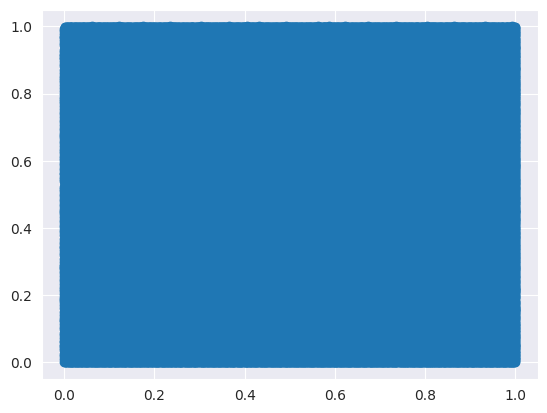

In [5]:
plt.scatter(mc_X[:, 0], mc_X[:, 1])
plt.show()

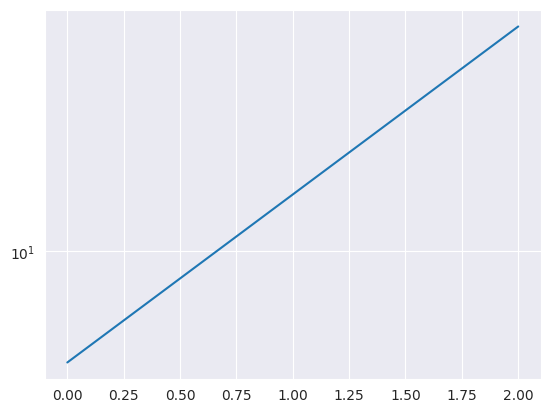

In [6]:
plt.plot(ns)
plt.yscale('log')

In [7]:
def init_true_model():
    true_model = hmm.GaussianHMM(n_components=3, covariance_type="full")

    true_model.startprob_ = np.array([0.6, 0.3, 0.1])
    true_model.transmat_ = np.array([[0.7, 0.2, 0.1], [0.3, 0.5, 0.2], [0.3, 0.3, 0.4]])

    true_model.means_ = np.array([[0.0, 0.0], [3.0, -3.0], [4.0, 3.0]])
    true_model.covars_ = (
        np.array(
            [
                [[1, -0.5], [-0.5, 1.2]],
                [[0.6, -0.5], [-0.5, 1.2]],
                [[1.5, 0.5], [0.5, 2.2]],
            ]
        )
        * 0.8
    )
    
    true_model.n_features = 2

    norm1 = multivariate_normal(true_model.means_[0], true_model.covars_[0])
    norm2 = multivariate_normal(true_model.means_[1], true_model.covars_[1])
    norm3 = multivariate_normal(true_model.means_[2], true_model.covars_[2])
    norms = [norm1, norm2, norm3]

    return true_model, norms

true_model, norms = init_true_model()
X, Z = true_model.sample(T)

In [8]:
minx, miny = X.min(axis=0)
maxx, maxy = X.max(axis=0)

total_area = (maxx - minx) * (maxy - miny)

mc_X[:, 0] = mc_X[:, 0] *  (maxx - minx)  + minx
mc_X[:, 1] = mc_X[:, 1] *  (maxy - miny)  + miny

In [9]:
mc_pdf = np.concatenate([norm.pdf(mc_X).reshape(1, -1) for norm in norms])
mc_pdf

array([[6.49513706e-04, 6.89265924e-09, 1.17132892e-05, ...,
        2.67294658e-13, 2.00437614e-11, 6.19566720e-05],
       [2.56401013e-02, 1.28020085e-20, 2.06515933e-05, ...,
        6.56287962e-21, 1.07638340e-25, 2.67641405e-05],
       [6.32022242e-04, 3.66274604e-12, 1.88435658e-08, ...,
        6.60192051e-05, 1.54838693e-12, 1.54533152e-02]])

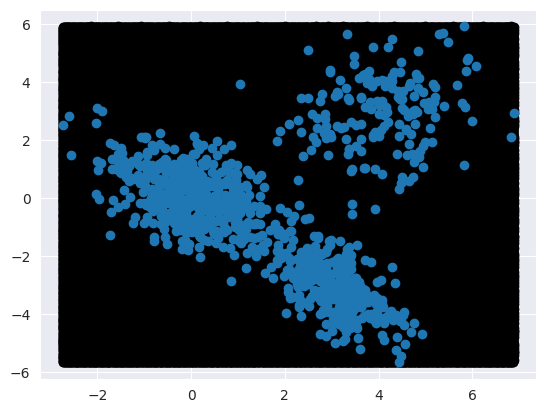

In [10]:
plt.scatter(mc_X[:, 0], mc_X[:, 1], color='black')
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [11]:
def init_model_with_params(discretize_meth, true_model_, X_train_, n):
    """
    Init DiscreteHMM with parameters from true model
    """
    model_ = DiscreteHMM(
        discretize_meth,
        n,
        n_components=3,
        learning_alg="cooc",
        verbose=True,
        params="mct",
        init_params="",
        optim_params=dict(max_epoch=50000, lr=0.1, weight_decay=0),
        n_iter=100,
    )

    model_.startprob_ = true_model_.startprob_
    model_.transmat_ = true_model_.transmat_
    model_.means_ = true_model_.means_
    model_.covars_ = true_model_.covars_

    model_._init(X_train_)
    model_.provide_nodes(X_train_, False)
    return model_

In [12]:
x1, y1 = X.min(axis=0) - .5
x2, y2 = X.max(axis=0) + .5

XX, YY = np.meshgrid(np.linspace(x1, x2, 100), np.linspace(y1, y2, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
lls = np.concatenate([norm.pdf(data).reshape(-1, 1) for norm in norms], axis=1)

In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', size=15) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=15) #fontsize of the x tick labels
plt.rc('ytick', labelsize=15) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend

title_strings = {'grid': 'OG',
                'random': 'RO',
                'latin_cube_u':  'LH',
                'latin_cube_q': 'LH_q',
                'sobol': 'QS',
                'uniform':'RU',
                'halton': 'QH'}

In [14]:
DISCRETIZATION_TECHNIQUES

['grid',
 'random',
 'latin_cube_u',
 'latin_cube_q',
 'uniform',
 'sobol',
 'halton']

Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update th

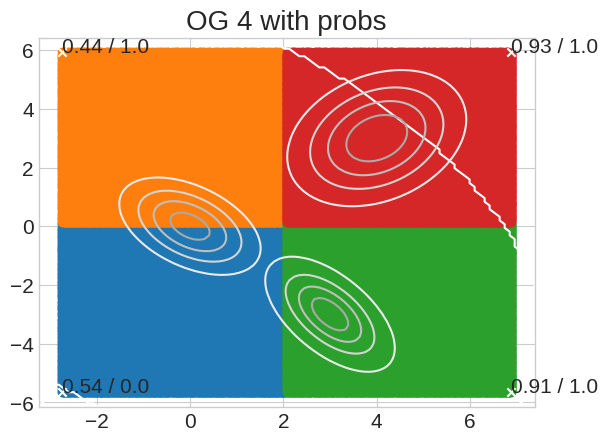

Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update th

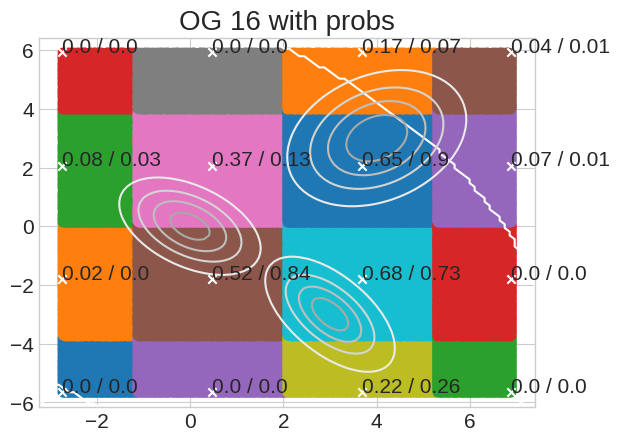

Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update th

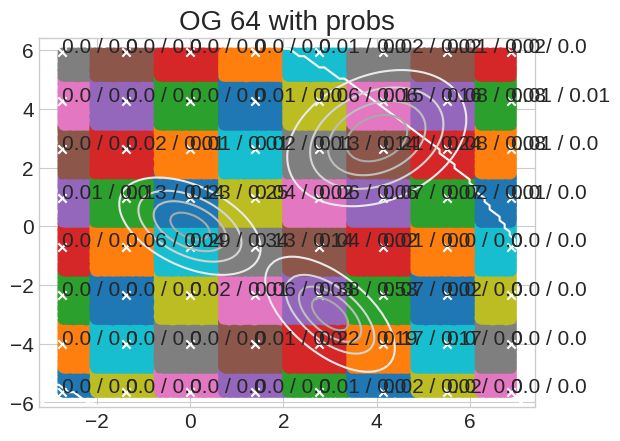

Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update th

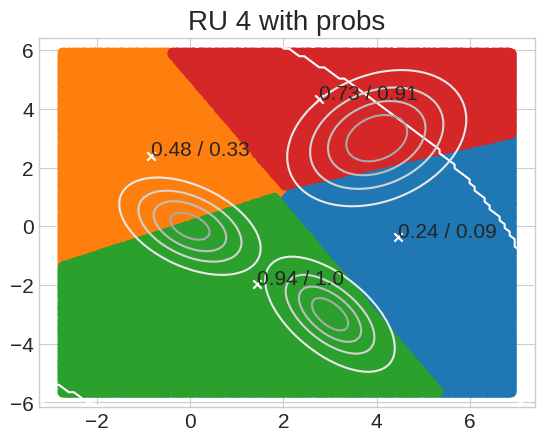

Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update th

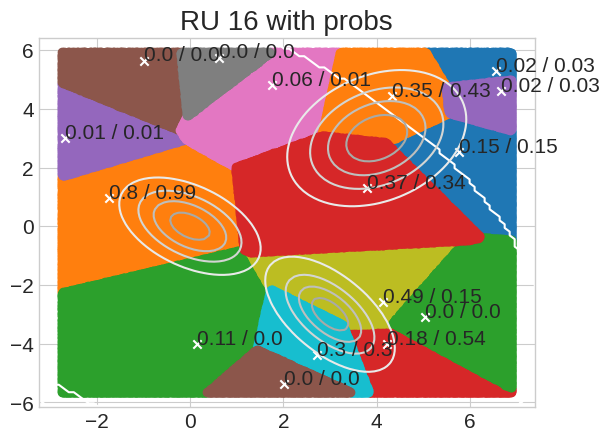

Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update them
Nodes have been already set. Use force=True to update th

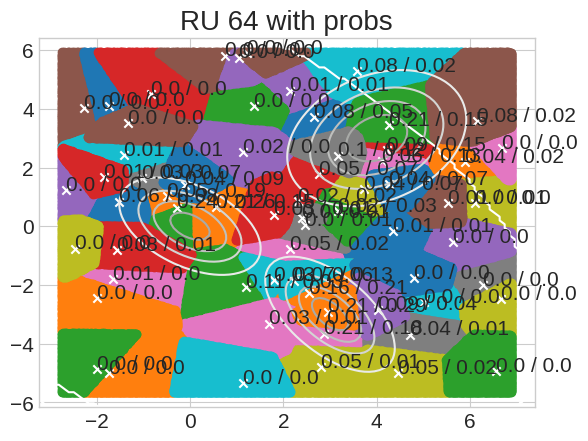

In [15]:
results = dd(list)
#  The likelihood is calculated for known states! we test only on emission!
# for discretize_meth, n in itertools.product(DISCRETIZATION_TECHNIQUES, ns):
# discretize_meth = 'grid'
# for n in ns:
for discretize_meth, n in itertools.product(['grid', 'uniform'], ns):
    for _ in range(100):
        # print(discretize_meth)
        model = init_model_with_params(discretize_meth, true_model, X, n)
        
        Xd = model.discretize(X, force=False)
        mc_d = model.discretize(mc_X, force=False)
        
        # TODO: score 1
        nodes_pdf = np.concatenate([norm.pdf(model.nodes.T).reshape(1, -1) for norm in norms])
        nodes_pdf /= nodes_pdf.sum(axis=1)[:, np.newaxis]
        log_approx = np.log(nodes_pdf[Z, Xd]).sum()
        # TODO: score 2
        nodes_pdf_exact = np.nan_to_num(
            np.concatenate(
                [mc_pdf[:, mc_d[:, 0] == i].sum(axis=1).reshape(-1, 1) / mc_pdf.shape[1] * total_area for i in range(model.no_nodes)], 
                axis=1), 
            0)
        log_exact = np.log(mc_pdf[Z, mc_d]).sum()  
        
        results[(discretize_meth, n)].append(dict(log_exact=log_exact, log_approx=log_approx))
    for i in range(n):
        plt.scatter(mc_X[mc_d.reshape(-1) == i, 0], mc_X[mc_d.reshape(-1) == i, 1])
    
    for k in range(model.n_components):
        plt.contour(XX, YY, np.exp(lls[:, k]).reshape(XX.shape), cmap=white_to_color_cmap(sns.xkcd_palette(['grey'])[0]), levels=4)
    plt.scatter(model.nodes[0], model.nodes[1], color='white', marker='x')
    plt.title(f"{title_strings[discretize_meth]} {n} with probs")
    for i in range(n):
        plt.annotate(f"{nodes_pdf_exact[:, i].max().round(2)} / {nodes_pdf[:, i].max().round(2)}", model.nodes[:, i])
    plt.savefig(f'MLinPL/{title_strings[discretize_meth]}_{n}.eps', format='eps')
    plt.savefig(f'MLinPL/{title_strings[discretize_meth]}_{n}.png', format='png')
    plt.show()

In [16]:
res_df = dict(grid=[], n=[], exact=[], approx=[])
for k, vs in results.items():
    for v_ in vs:
        res_df['grid'].append(title_strings[k[0]])
        res_df['n'].append(k[1])
        res_df['exact'].append(v_['log_exact'])
        res_df['approx'].append(v_['log_approx'])
res_df = pd.DataFrame(res_df)
res_df = res_df.melt(['grid', 'n'], var_name='prob_type', value_name='negative loglikelihood')

res_df['negative loglikelihood'] = res_df['negative loglikelihood'] * (-1) 

In [17]:
log_true = np.log([norms[z].pdf(x) for z, x in zip(Z, X)]).sum()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


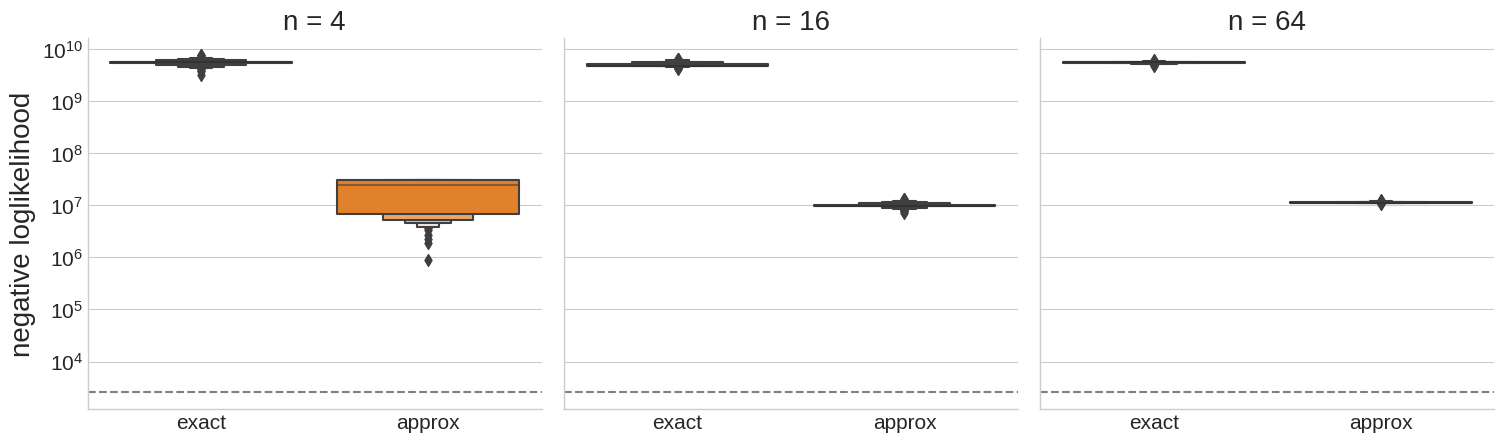

In [18]:
sns.catplot(res_df, # x='grid', 
            y='negative loglikelihood', col='n', x='prob_type', kind='boxen').refline(y=log_true * (-1), linestyle='--').set(xlabel=None)
plt.yscale('log')
plt.savefig('MLinPL/res_scratch_comp.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


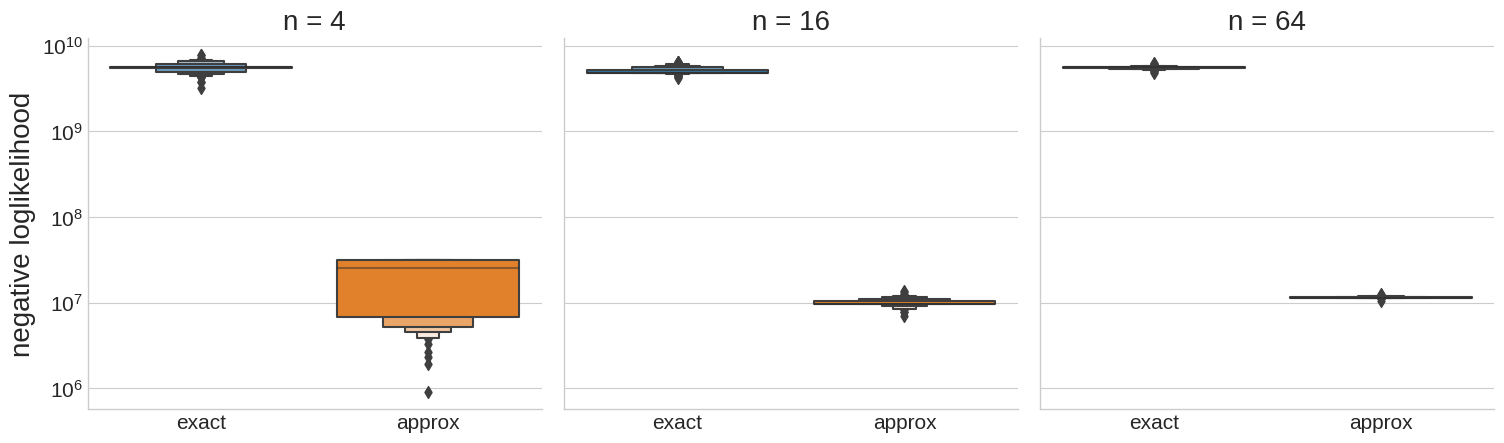

In [19]:
sns.catplot(res_df, # x='grid', 
            y='negative loglikelihood', col='n', x='prob_type', kind='boxen').set(xlabel=None)
plt.yscale('log')
plt.savefig('MLinPL/res_scratch2_comp.eps', format='eps')

In [20]:
import pickle as pkl
with open('MLinPL/results_comp.pkl', 'wb') as f:
    pkl.dump(results, f)